In [1]:
from nltk.corpus import wordnet as wn
import networkx as nx
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os
import pydot
import pandas
pandas.set_option('display.max_colwidth', -1)

In [2]:
sensekey2sense_rank = dict()
path = os.path.join(str(wn._root), 'index.sense')
with open(path) as infile:
    for line in infile:
        sensekey, offset, sense_rank, freq = line.strip().split(' ')
        sensekey2sense_rank[sensekey] = sense_rank
        

In [3]:
def get_label(synset):
    """
    extract label from WordNet synset object 
    
    :param nltk.corpus.reader.wordnet.Synset synset: wordnet synset
    
    :rtype: str
    :return synonyms \n offset-pos
    """
    pos = synset.pos()
    
    synonym_labels = []
    for lemma in synset.lemmas():

        sensekey = lemma.key()
        lemma = lemma.name()
        rank = sensekey2sense_rank[sensekey]

        synonym_label = f'{lemma}.{pos}.{rank}'
        synonym_labels.append(synonym_label)
        
    offset = synset.offset()
    offset = str(offset).zfill(8)
    
    return ', '.join(synonym_labels) + '\n' + 'eng-30-' + offset + '-' + pos


def synset2identifier(synset, wn_version):
    """
    return synset identifier of 
    nltk.corpus.reader.wordnet.Synset instance

    :param nltk.corpus.reader.wordnet.Synset synset: a wordnet synset
    :param str wn_version: supported: '171 | 21 | 30'

    :rtype: str
    :return: eng-VERSION-OFFSET-POS (n | v | r | a)
    e.g. 
    """
    offset = str(synset.offset())
    offset_8_char = offset.zfill(8)

    pos = synset.pos()
    if pos == 'j':
        pos = 'a'

    identifier = 'eng-{wn_version}-{offset_8_char}-{pos}'.format_map(locals())

    return identifier


def synsets_graph_info(wn_instance, wn_version, lemma, pos):
    """
    extract:
    1. hyponym under lowest least common subsumer

    :param nltk.corpus.reader.wordnet.WordNetCorpusReader wn_instance: instance
    of nltk.corpus.reader.wordnet.WordNetCorpusReader
    :param str wn_version: supported: '171' | '21' | '30'
    :param str lemma: a lemma
    :param str pos: a pos

    :rtype: dict
    :return: mapping synset_id 
        -> 'under_lcs' -> under_lcs identifier
        -> 'path_to_under_lcs' -> [sy1_iden, sy2_iden, sy3_iden, ...]
    """
    sy_id2under_lcs_info = dict()

    synsets = wn_instance.synsets(lemma, pos=pos)

    if len(synsets) == 1:
        target_sy_iden = synset2identifier(synsets[0], wn_version)
        sy_id2under_lcs_info[target_sy_iden] = {'under_lcs': None,
                                                'path_to_under_lcs': []}
        return sy_id2under_lcs_info

    for sy1 in synsets:

        target_sy_iden = synset2identifier(sy1, wn_version)

        min_path_distance = 100
        closest_lcs = None

        for sy2 in synsets:
            if sy1 != sy2:
                lcs_s = sy1.lowest_common_hypernyms(sy2)
                lcs = lcs_s[0]

                path_distance = sy1.shortest_path_distance(lcs)

                if path_distance < min_path_distance:
                    closest_lcs = lcs
                    min_path_distance = path_distance

        under_lcs = None
        for hypernym_path in sy1.hypernym_paths():
            for first, second in zip(hypernym_path, hypernym_path[1:]):
                if first == closest_lcs:
                    under_lcs = second

                    index_under_lcs = hypernym_path.index(under_lcs)
                    path_to_under_lcs = hypernym_path[index_under_lcs + 1:-1]

                    under_lcs_iden = synset2identifier(under_lcs, wn_version)
                    path_to_under_lcs_idens = [synset2identifier(synset, wn_version)
                                               for synset in path_to_under_lcs]

                    sy_id2under_lcs_info[target_sy_iden] = {'under_lcs': under_lcs_iden,
                                                            'under_lcs_obj' : under_lcs,
                                                            'path_to_under_lcs': path_to_under_lcs_idens}

    return sy_id2under_lcs_info

number of senses 3

CANDIDATE SYNSET Synset('communication.n.01') the activity of communicating; the activity of conveying information
lemmas [Lemma('communication.n.01.communication'), Lemma('communication.n.01.communicating')]
examples ['they could not act without official communication from Moscow']
HDN Synset('psychological_feature.n.01') a feature of the mental life of a living organism

CANDIDATE SYNSET Synset('communication.n.02') something that is communicated by or to or between people or groups
lemmas [Lemma('communication.n.02.communication')]
examples []
HDN Synset('communication.n.02') something that is communicated by or to or between people or groups

CANDIDATE SYNSET Synset('communication.n.03') a connection allowing access between persons or places
lemmas [Lemma('communication.n.03.communication')]
examples ['how many lines of communication can there be among four people?', 'a secret passageway provided communication between the two rooms']
HDN Synset('relation.n.01') 

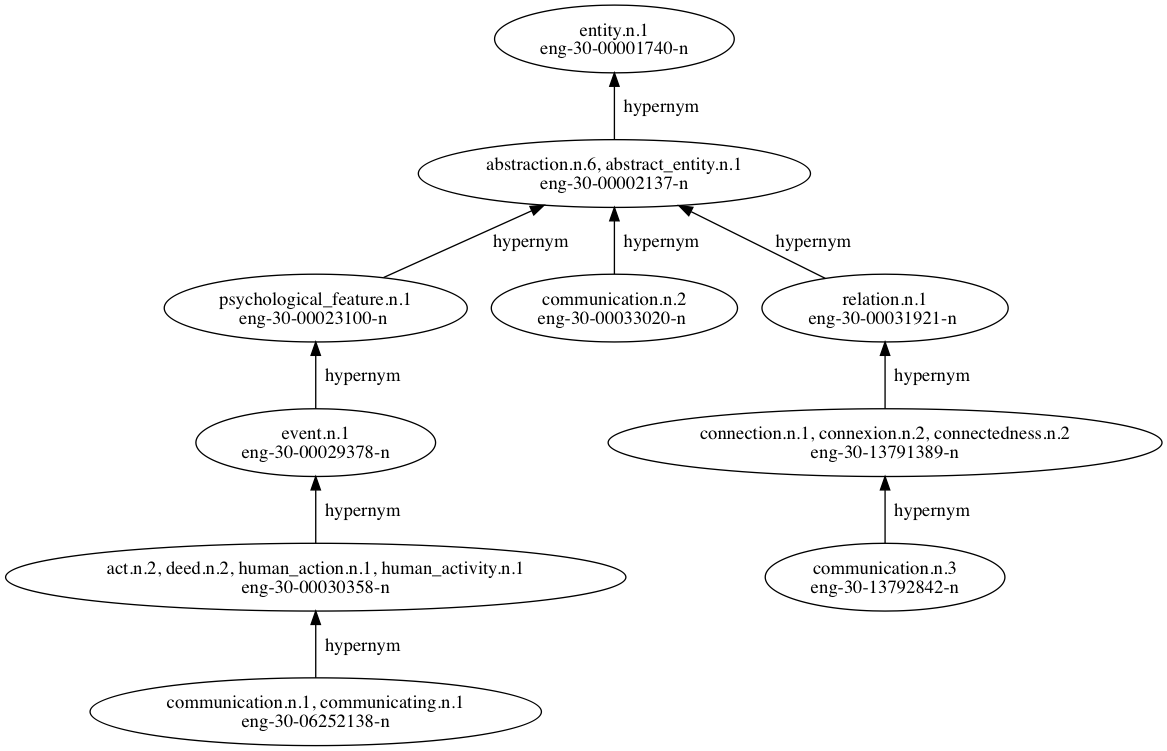

In [4]:
lemma = 'communication'
pos = 'n'
synsets = wn.synsets(lemma, pos=pos)
graph_info = synsets_graph_info(wn, '30', lemma, pos)

print('number of senses', len(synsets))
add_definitions = False
paper = False
#target_labels = {'horse.n.01', 'knight.n.02'}

edges = []
for synset in synsets:
    base_synset_iden = synset2identifier(synset, '30')
    hdn = graph_info[base_synset_iden]['under_lcs']
    hdn_obj = graph_info[base_synset_iden]['under_lcs_obj']
    print()
    print('CANDIDATE SYNSET', synset, synset.definition())
    print('lemmas', synset.lemmas())
    print('examples', synset.examples())
    print('HDN', hdn_obj, hdn_obj.definition())
    
    
    cand_label = synset.name()
    
    if paper:
        if cand_label not in target_labels:
            continue
        
    for path in synset.hypernym_paths():
        if len(path) >= 2:
            for hypernym, hyponym in zip(path[:-1], path[1:]):
                
                hyper_label = get_label(hypernym)
                hyper_iden = synset2identifier(hypernym, '30')
                hypo_label = get_label(hyponym)
                hypo_iden = synset2identifier(hyponym, '30')
                
                if any([hyper_label == cand_label,
                        hyper_iden == hdn]):
                    if not paper:
                        hyper_label = '%s ' % hyper_label
                    
                if any([hypo_label == cand_label,
                        hypo_iden == hdn]):
                    if not paper:
                        hypo_label = "%s " % hypo_label

                
                hyper_node_label = "{hyper_label}".format_map(locals())
                hypo_node_label = "{hypo_label}".format_map(locals())
                
                
                edges.append((hyper_node_label, hypo_node_label))
                
g = nx.DiGraph()
g.add_edges_from(edges, dir='back', label='  hypernym')


#g.add_node('1', shape='rect' )
#g.add_edge('1', 'communication.n.1, communicating.n.1\neng-30-06252138-n')


p=nx.drawing.nx_pydot.to_pydot(g)
p.write_png('wn_structure.png')
display(Image(filename='wn_structure.png'))

In [48]:
synset_labels = ['communication.n.01', 
                 'communication.n.02', 
                 'communication.n.03'
                ]



list_of_lists = []
headers = ['synonym', 'sensekey', 'synset identifier', 'definition', 'examples']
target_lemma = 'communication'

for synset_label in synset_labels:
    
    synonym = synset_label
    synset = wn.synset(synset_label)
    
    for lemma in synset.lemmas():
        if lemma.name() == target_lemma:
            sensekey = lemma.key()
            
    offset = synset.offset()
    pos = synset.pos()
    offset = str(offset).zfill(8)
    ili = f'eng-30-{offset}-{pos}'
    
    definition = synset.definition()
    examples = synset.examples()
    if not examples:
        examples = 'N/A'
    else:
        examples = ';'.join(examples)
            
    
    
    one_row = [synonym, sensekey, ili, definition, examples]
    list_of_lists.append(one_row)

df = pandas.DataFrame(list_of_lists, columns=headers)

latex_table = df.transpose().to_latex()
with open('communication.tex', 'w') as outfile:
    outfile.write(latex_table)

In [49]:
cat communication.tex

\begin{tabular}{llll}
\toprule
{} &                                                                     0 &                                                                    1 &                                                                                                                                 2 \\
\midrule
synonym           &  communication.n.01 &  communication.n.02 &  communication.n.03 \\
sensekey          &  communication\%1:10:01:: &  communication\%1:03:00:: &  communication\%1:24:00:: \\
synset identifier &  eng-30-06252138-n &  eng-30-00033020-n &  eng-30-13792842-n \\
definition        &  the activity of communicating; the activity of conveying information &  something that is communicated by or to or between people or groups &  a connection allowing access between persons or places \\
examples          &  they could not act without official communication from Moscow &  N/A &  how many lines of communication can there be among four people?;a secret passageway prov

In [39]:
wn.synset('communication.n.3').topic_domains()

[]

In [22]:
dir(synset)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_all_hypernyms',
 '_definition',
 '_examples',
 '_frame_ids',
 '_hypernyms',
 '_instance_hypernyms',
 '_iter_hypernym_lists',
 '_lemma_names',
 '_lemma_pointers',
 '_lemmas',
 '_lexname',
 '_max_depth',
 '_min_depth',
 '_name',
 '_needs_root',
 '_offset',
 '_pointers',
 '_pos',
 '_related',
 '_shortest_hypernym_paths',
 '_wordnet_corpus_reader',
 'also_sees',
 'attributes',
 'causes',
 'closure',
 'common_hypernyms',
 'definition',
 'entailments',
 'examples',
 'frame_ids',
 'hypernym_distances',
 'hypernym_paths',
 'hypernyms',
 'hyponyms',
 'instance_hypernyms',
 'instance_hyponyms',
 'jcn

In [47]:
for synset in wn.synsets('communication', 'n'):
    print()
    print(synset)
    for lemma in synset.lemmas():
        print(lemma.name(), lemma.key())


Synset('communication.n.01')
communication communication%1:10:01::
communicating communicating%1:10:00::

Synset('communication.n.02')
communication communication%1:03:00::

Synset('communication.n.03')
communication communication%1:24:00::
